<a href="https://colab.research.google.com/github/astroChance/RadNET/blob/master/RadNET_Frontend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Directories

In [6]:
!pip install --upgrade segyio
import segyio
import numpy as np
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import time
import itertools
import os
import re
import random
from PIL import Image
from scipy import spatial, signal
import json
from sklearn.preprocessing import StandardScaler


# plt.style.use('classic')
plt.style.use('seaborn-poster')

Requirement already up-to-date: segyio in /usr/local/lib/python3.6/dist-packages (1.9.3)


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
### Data filepaths

# 3D

Volume3D = "/content/drive/My Drive/RadNET/GAN data/3D/PB3D_Fritz_subset.sgy"

# 2D

TwoDFiles = []
for root, dirs, files in os.walk("/content/drive/My Drive/RadNET/GAN data/2D"):
    for name in files:
        filename = os.path.join(root, name)
        TwoDFiles.append(filename)
print("2D files in directory: ", len(TwoDFiles))

2D files in directory:  139


# Create 2D-3D Trace Match Dictionary

In [ ]:
"""
Design dictionary of:
{2D line number from filename : { 2D trace number : corresponding 3D trace number}

NOTE: Placing TRACE_SEQUENCE_LINE header into match dictionary requires a -1 to be
used later when accessing traces (numpy index != TRACE_SEQUENCE_LINE)

Due to runtime limitations in Colab, write each 2D dict to json file then
concatenate in next cell
"""



# 3D trace coord dictionary, {(Xcoord, Ycoord) : 3D trace number}
# Create array of XY coords for min dist calculation
Trace_coords_3D = {}
coord_3D = np.array([])
counter3D = 0
with segyio.open(Volume3D, 'r') as segyfile:
  for i in range(len(segyfile.trace)):
    Trace_coords_3D[(segyfile.header[i][segyio.TraceField.GroupX], segyfile.header[i][segyio.TraceField.GroupY])] = segyfile.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]
    tr_coord = np.array([ segyfile.header[i][segyio.TraceField.GroupX], segyfile.header[i][segyio.TraceField.GroupY] ])
    if counter3D == 0:
      coord_3D = np.append(coord_3D, tr_coord)
    else:
      coord_3D = np.vstack((coord_3D, tr_coord))
    counter3D =+ 1

print("3D trace dictionary complete")


# For each 2D line, build dictionary to map 2D trace number
# to closest 3D trace number

TEMP_DICT = {}

line_counter=1
for radar_line in TwoDFiles[52:]:
  with segyio.open(radar_line, 'r') as line:
    line_num = os.path.basename(radar_line).split(".")[0]

    TEMP_DICT = {}
    TEMP_DICT[line_num] = {}

    trace_counter=1
    for i in range(len(line.trace)):
      trace_2D = line.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]
      
      ## Find 3D nearest neighbor for x and y
      ## minimize (dx + dy)
      coord_2D = np.array([ line.header[i][segyio.TraceField.GroupX], line.header[i][segyio.TraceField.GroupY] ])
      
      closest_3Dtrace = coord_3D[spatial.KDTree(coord_3D).query(coord_2D)[1]]
      closest_3Dtrace = tuple(closest_3Dtrace)

      ## Build the dictionary
     
      TEMP_DICT[line_num][trace_2D] = [Trace_coords_3D[closest_3Dtrace]]
      
      print("\rLine number ", line_counter, "\tTrace number ", trace_counter, "\\",len(line.trace), end="", flush=True)
      trace_counter+=1

    temp_Dict = "/content/drive/My Drive/RadNET/GAN data/tempdicts/" + str(line_num) + ".json"
    with open(temp_Dict, 'w') as dict_file:
      json.dump(TEMP_DICT, dict_file)

    line_counter+=1


print("\nIndividual dictionaries complete")

In [ ]:
# Check json file count
# Place all individual dicts into master dict

Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"

Trace_Matcher = {}

indv_dicts = []
for root, dirs, files in os.walk("/content/drive/My Drive/RadNET/GAN data/tempdicts"):
    for name in files:
        filename = os.path.join(root, name)
        indv_dicts.append(filename)
print("2D files in directory: ", len(indv_dicts))

for dic in indv_dicts:
  with open(dic, 'r') as temp_dict:
    tempdict = json.load(temp_dict)
    Trace_Matcher.update(tempdict)


with open(Trace_Map_Dict, 'w') as dict_file:
      json.dump(Trace_Matcher, dict_file)

In [ ]:
# QC the trace match dictionary

Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

print("Loaded data type: ", type(TraceDict))

trace_count=0
for k,v in TraceDict.items():
  trace_count = trace_count + len(v)

print("Trace matched pairs: ", trace_count)

print("Random Sample: ", random.choice(list(TraceDict.items())))

# Visual QC of Matched Sections

2D line:  1738402000
2D trace:  63
3D trace:  25601


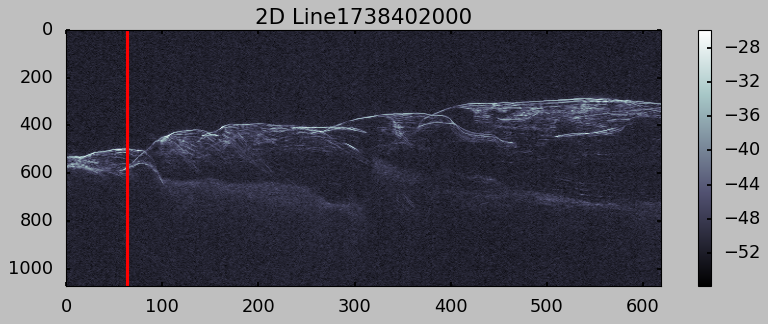

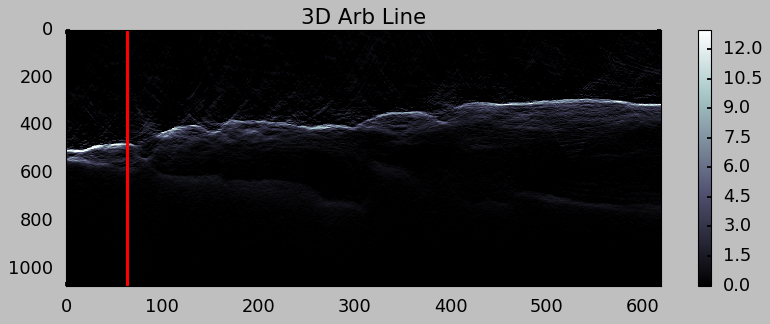

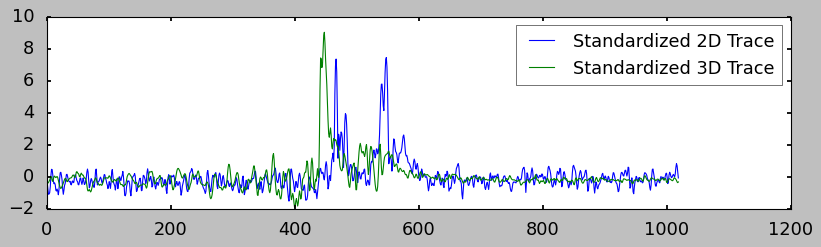

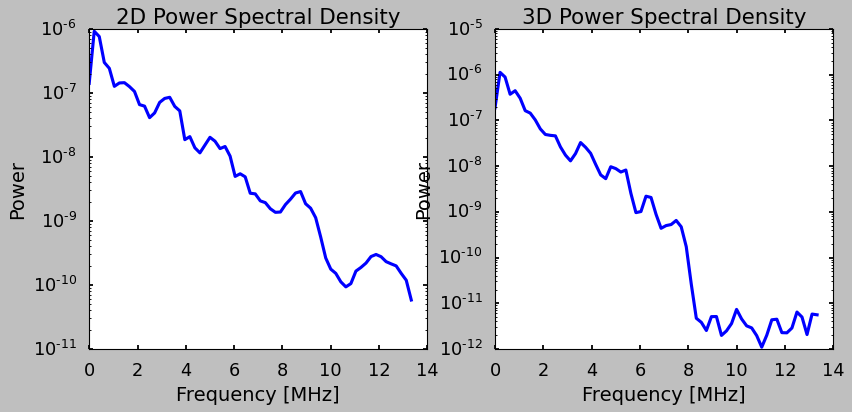

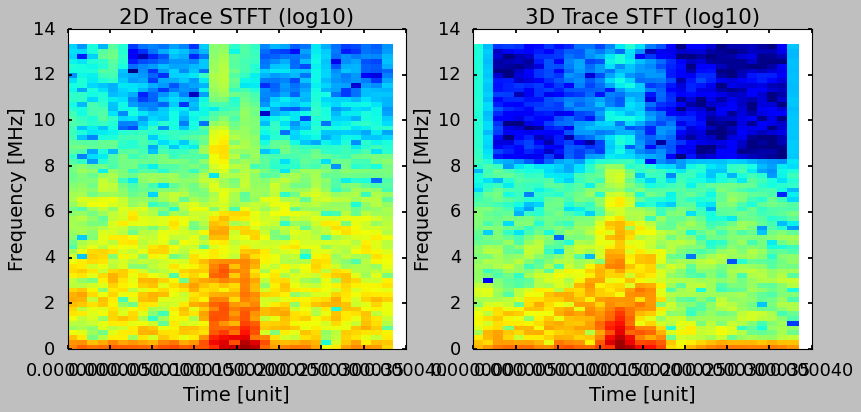

In [17]:
"""
Display 2D and corresponding 3D line sections

Display standardized matched traces

Display PSD and Magnitude Spectrograms of standardized matched traces

"""


####!!!!!!!  REPLACE WITH SMARTER MATCHING?
#
# Trimming 2D data to approximately match 3D
trace_len_clip_2D_start = 1970
trace_len_clip_2D_end = 3040


# Load dictionary to get 2D / 3D trace relationships
Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

# Randomly choose value from trace match dictionary
Rand2D = random.choice(list(TraceDict.items()))
RandTraceMatch = random.choice(list(Rand2D[1].items()))

# Set the random choice to variables, print information
Rand2DLine = int(Rand2D[0])
Rand2DTrace = int(RandTraceMatch[0]) - 1
Rand3DTrace = int(RandTraceMatch[1][0]) - 1

print("2D line: ", Rand2DLine)
print("2D trace: ", Rand2DTrace)
print("3D trace: ", Rand3DTrace)


# Get 2D and 3D data
Rand2DFile = "/content/drive/My Drive/RadNET/GAN data/2D/" + str(Rand2DLine) + ".sgy"
with segyio.open(Rand2DFile, 'r') as segyfile:
  display_line2D = segyio.tools.collect(segyfile.trace[:])
  display_line2D = display_line2D[:,trace_len_clip_2D_start:trace_len_clip_2D_end]
  display_trace_2D = segyfile.trace[Rand2DTrace]
  display_trace_2D = display_trace_2D[trace_len_clip_2D_start:trace_len_clip_2D_end]

with segyio.open(Volume3D, 'r') as segyfile:
  display_trace_3D = segyfile.trace[Rand3DTrace]
  counter = 0
  display_line3D = np.array([])
  for tr in Rand2D[1].values():

    if counter == 0:
      display_line3D = np.append(display_line3D, segyfile.trace[tr[0]])
    else:
      display_line3D = np.vstack((display_line3D, segyfile.trace[tr[0]]))
    counter += 1

# Using StandardScaler to adjust relative ampltidues of 2D and 3D traces
scaler2D = StandardScaler()    
scaler3D = StandardScaler()
standardized_2D_trace = scaler2D.fit_transform(np.expand_dims(display_trace_2D, axis=1))
standardized_3D_trace = scaler3D.fit_transform(np.expand_dims(display_trace_3D, axis=1))


# Extra trim applied to shape spectrogram array size
# Done for image size convenience, can revisit later
standardized_2D_trace = np.squeeze(standardized_2D_trace[30:-20])
standardized_3D_trace = np.squeeze(standardized_3D_trace[30:-20])


# Paramters for STFT
fs = 1 / 0.0000000375     #sample frequency
nperseg = 128        # Potential nperseg/noverlap combos to use: (128, 96), (256,192/128)
noverlap = 96
window = signal.hann(nperseg, sym=False)

# Display parameters for Spectrograms
colormap = 'jet'
min_val = -10
max_val = 1
shading = 'flat'

# Use Welch method to get Power Spectral Density
freqs_2D, PSD_2D = signal.welch(standardized_2D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
freqs_3D, PSD_3D = signal.welch(standardized_3D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)

# Run STFT on standardized traces
f2D, t2D, Zxx2D = signal.stft(standardized_2D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
f3D, t3D, Zxx3D = signal.stft(standardized_3D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)


# Make plots
plt.figure(figsize=(12,4))
plt.title("2D Line" + str(Rand2DLine))
plt.imshow(display_line2D.T, cmap='bone', aspect='auto')
plt.axvline(Rand2DTrace, color='red')
plt.colorbar()

plt.figure(figsize=(12,4))
plt.title("3D Arb Line")
plt.imshow(display_line3D.T, cmap='bone', vmin = 0, vmax = 13, aspect='auto')
plt.axvline(Rand2DTrace, color='red')
plt.colorbar()

plt.figure(figsize=(12,3))
plt.plot(standardized_2D_trace, linewidth=1, label='Standardized 2D Trace')
plt.plot(standardized_3D_trace, linewidth=1, label='Standardized 3D Trace')
plt.legend()
plt.show()


fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].semilogy(freqs_2D/1000000, PSD_2D)  # div by 1e6 to display MHz
ax[0].set_ylabel('Power')
ax[0].set_xlabel('Frequency [MHz]')
ax[0].set_title('2D Power Spectral Density')

ax[1].semilogy(freqs_3D/1000000, PSD_3D)  # div by 1e6 to display MHz
ax[1].set_ylabel('Power')
ax[1].set_xlabel('Frequency [MHz]')
ax[1].set_title('3D Power Spectral Density')
plt.show()


fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].pcolormesh(t2D, f2D/1000000, np.log(np.abs(Zxx2D)), cmap=colormap, vmin=min_val, vmax=max_val, shading='flat')  # div by 1e6 to display MHz
ax[0].set_ylabel('Frequency [MHz]')
ax[0].set_xlabel('Time [unit]')
ax[0].set_title('2D Trace STFT (log10)')

ax[1].pcolormesh(t3D, f3D/1000000, np.log(np.abs(Zxx3D)), cmap=colormap, vmin=min_val, vmax=max_val, shading='flat')   # div by 1e6 to display MHz
ax[1].set_ylabel('Frequency [MHz]')
ax[1].set_xlabel('Time [unit]')
ax[1].set_title('3D Trace STFT (log10)')
plt.show()